# Reinforcement Learning from Human Feedback Using PPO


Estimated time needed: **30** minutes



Imagine you are an AI engineer who wants to train a "Happy LLM" and a "Pessimistic LLM" to train customer service agents. You have a reward function trained on the sentiment classifier from the IMDb dataset, and you will now use Reinforcement Learning (RL). RL is a subfield of machine learning where an agent learns to make decisions by performing actions in an environment to maximize a cumulative reward. The agent, in this case, will be the LLM, and the decisions will be about what text to output. Unlike supervised learning, which requires labeled input/output pairs, RL relies on the agent exploring the environment and learning from the feedback it receives in the form of rewards or penalties. This trial-and-error approach enables the agent to improve its decision-making strategy over time.

Proximal Policy Optimization (PPO) is one of the most effective and widely used RL algorithms. Introduced by OpenAI, PPO strikes a balance between simplicity and performance, making it a popular choice for training RL agents. PPO optimizes the policy directly and employs mechanisms to ensure the updates are not too drastic, thereby maintaining stability and reliability during training.

In this lab, you will be guided through the process of training an RL agent using the PPO algorithm with a focus on sentiment analysis. You will use the IMDb dataset, a large collection of movie reviews, to train your model. By the end of this lab, you will have a solid understanding of how to implement and train an RL agent using PPO, and you will be equipped with practical skills to apply RL techniques to other problems and datasets.
This lab is based on [a HF example code titled `Tune GPT2 to generate positive reviews`](https://github.com/huggingface/trl/blob/main/examples/notebooks/gpt2-sentiment.ipynb).




---
**Proximal Policy Optimization Setup**


In a **Proximal Policy Optimization (PPO)** training pipeline for large language models (LLMs), these four components play distinct and critical roles. The overall goal is to refine the model to generate responses that are aligned with human preferences, which are encoded by the reward model.


1.   **Model (or Policy)** : The language model being trained to generate responses. In the context of PPO, this is often called the "actor." It learns to generate text that maximizes the reward signals it receives.
2.   **Ref_Model (or Reference Model)**	: A frozen, non-trainable version of the model from an earlier stage of training. This model serves as a reference point to prevent the main model from changing too drastically or catastrophically during an update. The *Kullback-Leibler (KL) divergence* between the model and the ref_model is used as a penalty term in the loss function, ensuring the new policy stays "proximal" to the old one.
3. **Reward Model**	: A separate, static model trained to predict a scalar reward for a given prompt and its generated response. It acts as a "judge" that evaluates the quality of the model's output based on human preferences, which were encoded during the reward model's own training phase. The reward model is not updated during PPO training.
4. **Value Model**	: A separate model, often a small head on top of the main model's architecture, that learns to predict the expected cumulative future reward from a given state (e.g., a specific text sequence). In an Actor-Critic setup, this is called the "critic" and it helps stabilize training by providing a baseline for the reward signal, allowing the actor to focus on a measure of relative performance called the "advantage".

**Proximal Policy Optimization Trainign Cycle**

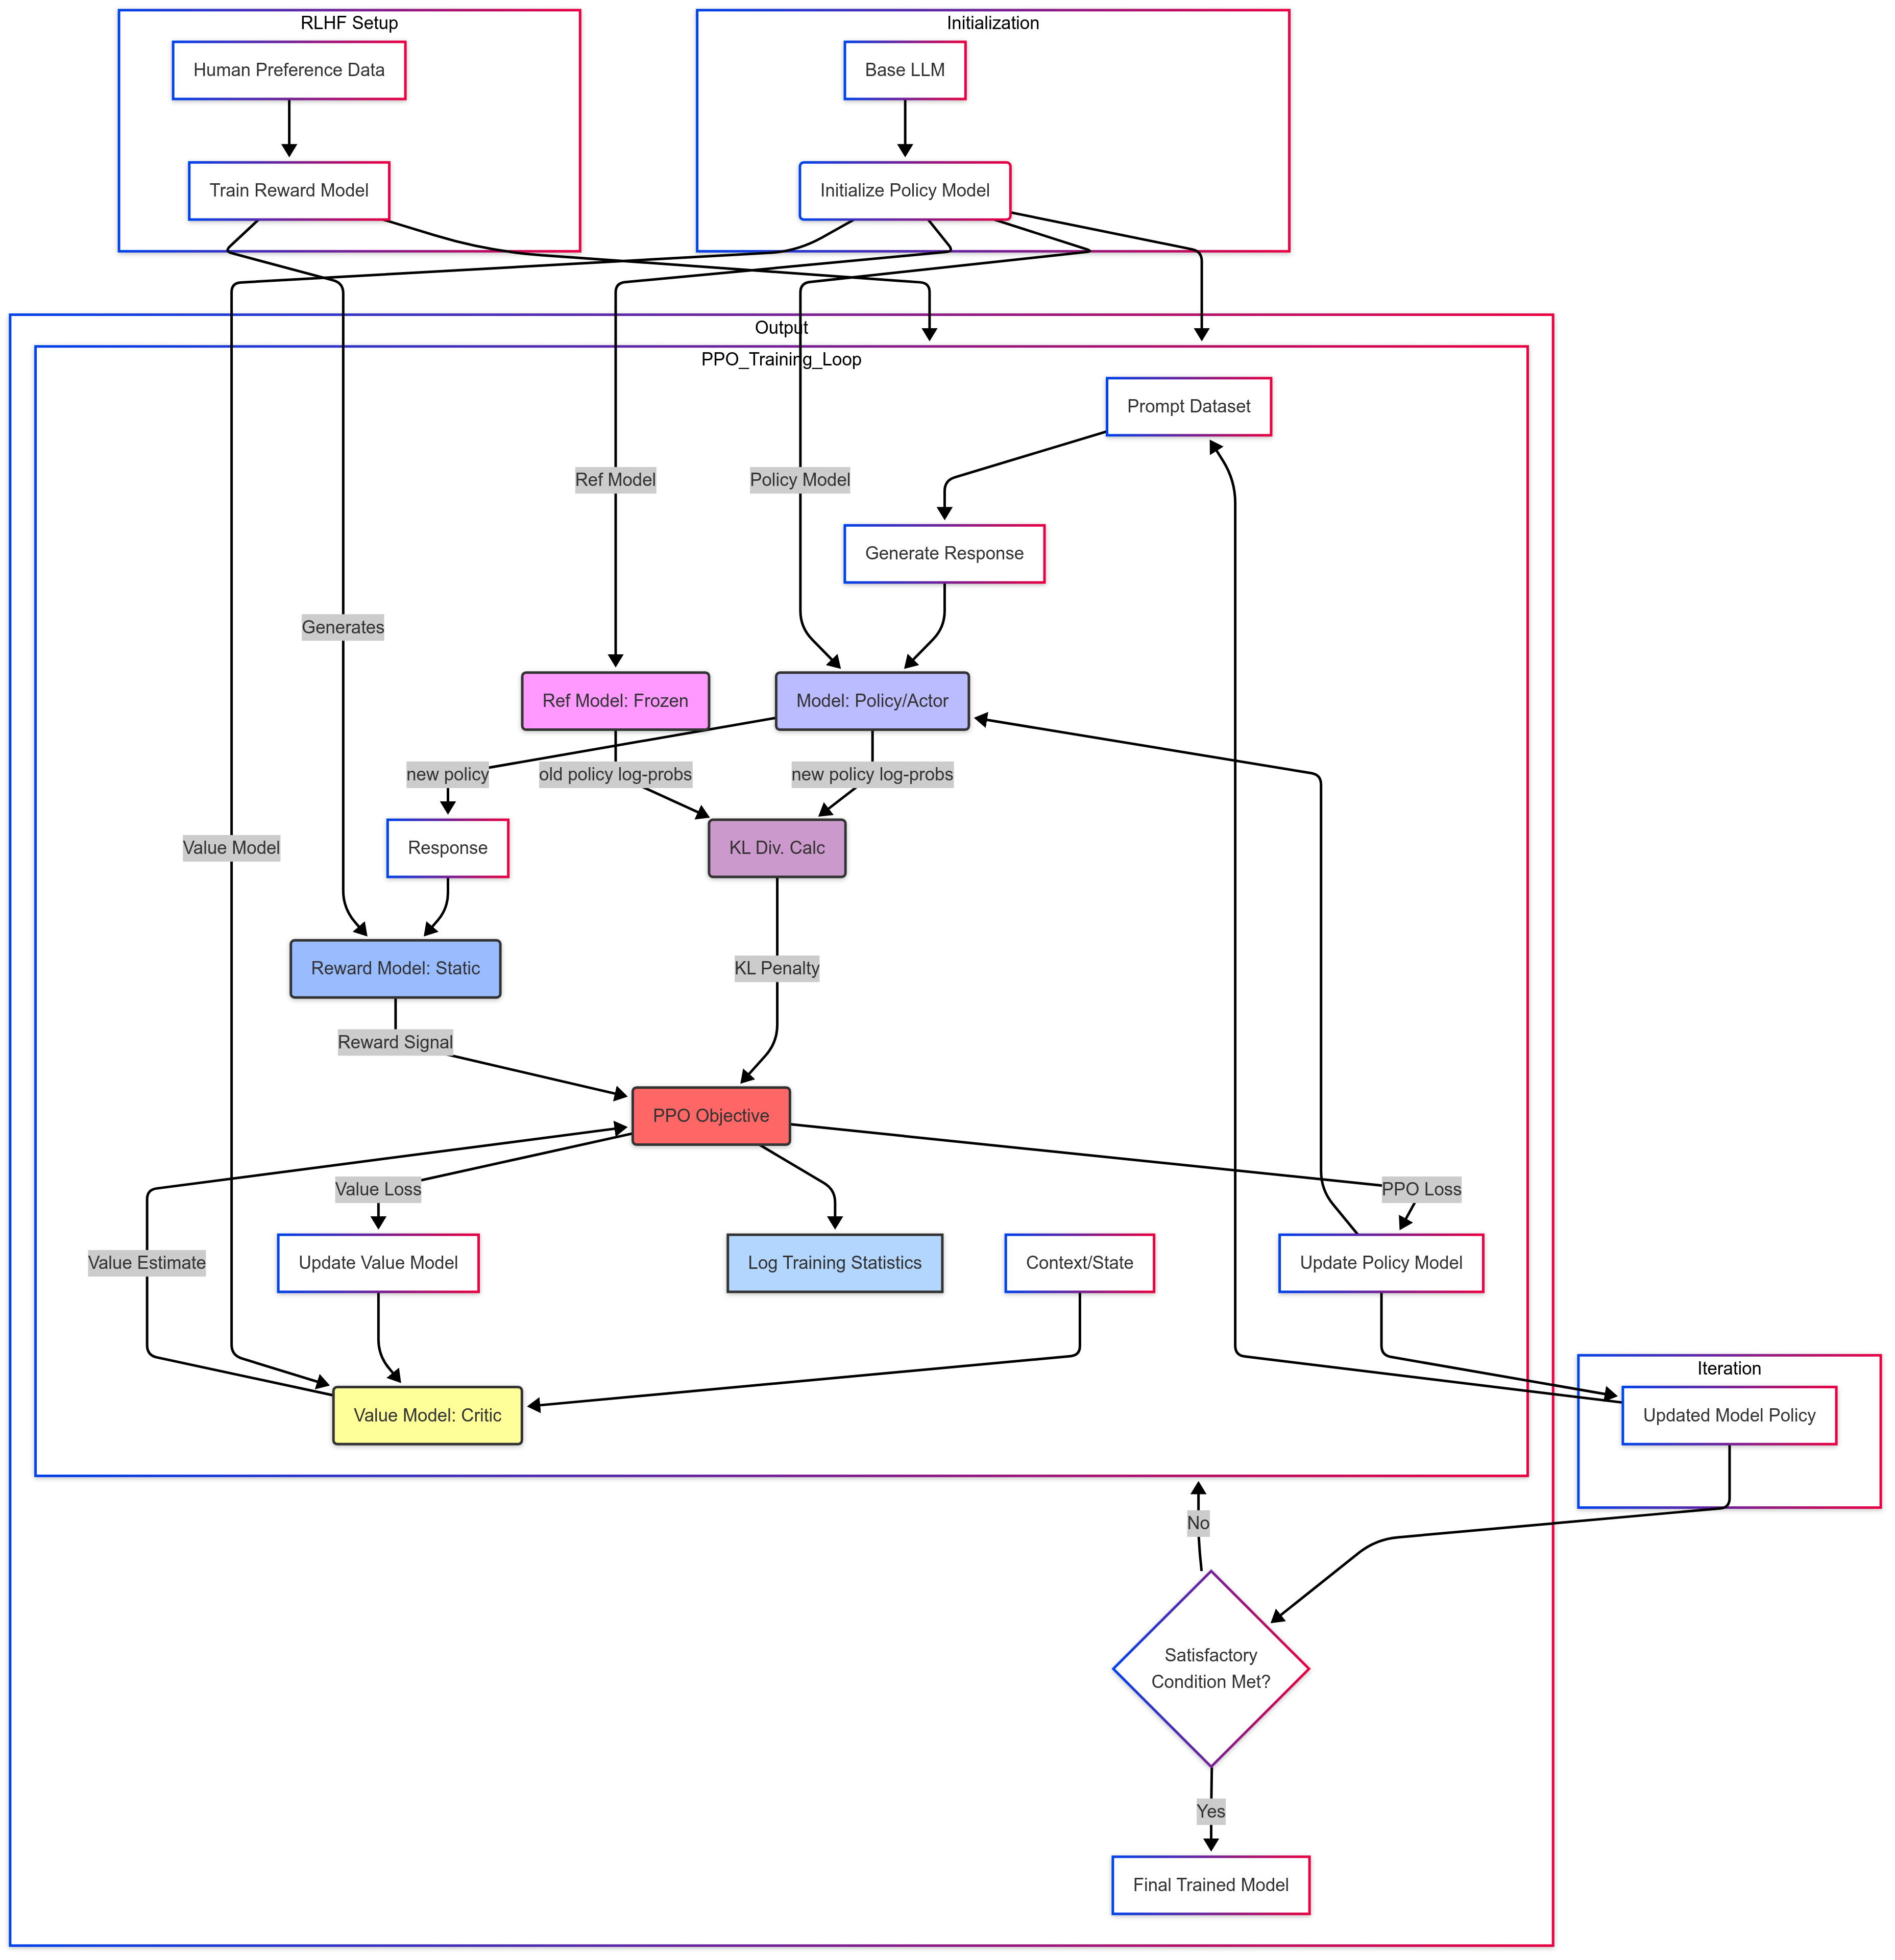

## __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-required-libraries">Installing required libraries</a></li>
            <li><a href="#Importing-required-libraries">Importing required libraries</a></li>
            <li><a href="#Defining-helper-functions">Defining helper functions</a></li>
        </ol>
    </li>
    <li><a href="#Initializing-the-PPO-configuration,-model,-and-tokenizer">Initializing the PPO configuration, model, and tokenizer</a></li>
            <li><a href="#Dataset-and-dataset-tokenization">Dataset and dataset tokenization</a></li>
            <li><a href="#Collator-function">Collator function</a></li>
            <li><a href="#Initialize-PPOTrainer">Initialize PPOTrainer</a></li>
            <li><a href="#Reward-function">Reward function</a></li>
    <li>
        <a href="#Generating-responses-using-PPO">Generating responses using PPO</a>
        <ol>
            <li><a href="#Tokenizing-and-preparing-the-input-batch">Tokenizing and preparing the input batch</a></li>
            <li><a href="#Scoring-function">Scoring function</a></li>
            <li><a href="#Proximal-policy-optimization">Proximal policy optimization</a></li>
        </ol>
    </li>
    <li><a href="#Plotting-PPO-training-loss-and-mean">Plotting PPO training loss and mean</a></li>
    <li><a href="#Generating-and-analyzing-text-with-PPO-and-reference-models">Generating and analyzing text with PPO and reference models</a></li>
    <li>
        <a href="#Comparing-PPO-and-reference-models-on">Comparing PPO and reference models on</a>
        <ol>
        </ol>
    </li>
                <li><a href="#Running-the-PPO-model-with-negative-sentiment">Running the PPO model with negative sentiment</a></li>
            <li><a href="#Comparing-models-with-negative-sentiment">Comparing models with negative sentiment</a></li>
            <li><a href="#Exercise:-Comparing-PPO-models">Exercise: Comparing PPO models</a></li>
</ol>


## Objectives

After completing this lab you will be able to:

- Apply the basics of reinforcement learning and proximal policy optimization (PPO).
- Set up the environment and load the IMDb dataset for training.
- Define and configure the PPO agent and tokenizer.
- Implement the PPO training loop.
- Generate and evaluate text responses from the trained model.
- Compare the performance of two models on the dataset.
- Save and load the trained model for future use.


----


## Setup


For this lab, you will use the following libraries:

*   [`pandas`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for managing the data.
*   [`torch`](https://pytorch.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for tensor operations and model training.
*   [`tqdm`](https://tqdm.github.io/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for progress bars.
*   [`transformers`](https://huggingface.co/transformers/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for pretrained language models.
*   [`datasets`](https://huggingface.co/docs/datasets/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for loading and processing datasets.
*   [`trl`](https://github.com/lvwerra/trl/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for Proximal Policy Optimization (PPO) training.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for plotting tools.
*   [`tarfile`](https://docs.python.org/3/library/tarfile.html/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for handling tar file operations.
*   [`pickle`](https://docs.python.org/3/library/pickle.html/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for serializing and deserializing Python objects.
*   [`json`](https://docs.python.org/3/library/json.html/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for parsing and writing JSON data.


### Installing required libraries

The following required libraries are __not__ preinstalled in the Skills Network Labs environment. __You must run the following cell__ to install them:

**Note:** The version has been pinned to specify the version. It's recommended that you do this as well. Even if the library is updated in the future, the installed library could still support this lab work.

This might take approximately 1 minute.


In [1]:
!pip install --user torch torchtext torchvision
!pip install --user datasets
!pip install --user trl
!pip install --user transformers
!pip install --user nltk rouge_score
!pip install --user matplotlib
!pip install numpy

### Importing required libraries

_It is recommended that you import all required libraries in one place (here):_


In [2]:
import torch
from tqdm import tqdm
import pandas as pd

tqdm.pandas()

from transformers import pipeline, AutoTokenizer,AutoModelForCausalLM
from datasets import load_dataset

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler
import os

import tarfile
import pickle
import json
import matplotlib.pyplot as plt
import torch
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
# Disable warnings for a cleaner notebook or console experience
def warn(*args, **kwargs):
    pass
warnings.warn = warn

## Defining helper functions


In [3]:
def save_to_json(data, file_path):
    """
    Save a dictionary to a JSON file.

    Args:
        data (dict): The dictionary to save.
        file_path (str): The path to the JSON file.
    """
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Data successfully saved to {file_path}")


def load_from_json(file_path):
    """
    Load data from a JSON file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The data loaded from the JSON file.
    """
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data


In [4]:
def pad_sequence_to_length(tensor, length, pad_token_id):
    padding_length = length - tensor.size(0)
    if padding_length > 0:
        padding = torch.full((padding_length,), pad_token_id, dtype=torch.long, device=tensor.device)
        return torch.cat((tensor, padding))
    return tensor

def pad_list_to_batch_size(tensors, batch_size, pad_token_id):
    max_length = max(t.size(0) for t in tensors)
    padded_tensors = [pad_sequence_to_length(t, max_length, pad_token_id) for t in tensors]

    # Add additional padding-only tensors if needed
    while len(padded_tensors) < batch_size:
        padded_tensors.append(torch.full((max_length,), pad_token_id, dtype=torch.long, device=tensors[0].device))

    return padded_tensors[:batch_size]

In [5]:
def print_ppo_stats(stats, related_to_objective=False):
    print("PPO Training Statistics\n")

    if related_to_objective:
        print("Objective Statistics:")
        print(f"  KL Divergence (objective/kl): {stats['objective/kl']}")
        print(f"  KL Coefficient (objective/kl_coef): {stats['objective/kl_coef']}")
        print(f"  Entropy (objective/entropy): {stats['objective/entropy']}\n")

        print("PPO Losses (Related to Minimizing Objective Function):")
        print(f"  Policy Loss (ppo/loss/policy): {stats['ppo/loss/policy']}")
        print(f"  Value Loss (ppo/loss/value): {stats['ppo/loss/value']}")
        print(f"  Total Loss (ppo/loss/total): {stats['ppo/loss/total']}\n")

        print("PPO Policy Statistics:")
        print(f"  Policy Entropy (ppo/policy/entropy): {stats['ppo/policy/entropy']}")
        print(f"  Approx KL (ppo/policy/approxkl): {stats['ppo/policy/approxkl']}")
        print(f"  Clip Fraction (ppo/policy/clipfrac): {stats['ppo/policy/clipfrac']}\n")
    else:
        print("Reward and Value Function Estimation:")
        print(f"  Mean Non-Score Reward (ppo/mean_non_score_reward): {stats['ppo/mean_non_score_reward']}")
        print(f"  Mean Scores (ppo/mean_scores): {stats['ppo/mean_scores']}")
        print(f"  Std Scores (ppo/std_scores): {stats['ppo/std_scores']}")
        print(f"  Value Prediction (ppo/val/vpred): {stats['ppo/val/vpred']}")
        print(f"  Value Prediction Error (ppo/val/error): {stats['ppo/val/error']}")
        print(f"  Value Prediction Variance (ppo/val/var): {stats['ppo/val/var']}")
        print(f"  Value Prediction Mean (ppo/val/mean): {stats['ppo/val/mean']}")
        print(f"  Explained Variance (ppo/val/var_explained): {stats['ppo/val/var_explained']}\n")

    print("Token Lengths:")
    print(f"  Queries Length Mean (tokens/queries_len_mean): {stats['tokens/queries_len_mean']}")
    print(f"  Responses Length Mean (tokens/responses_len_mean): {stats['tokens/responses_len_mean']}\n")

    print("Time Statistics:")
    print(f"  Total Time (time/ppo/total): {stats['time/ppo/total']} seconds\n")

# Example usage with the provided stats and the flag

## Initializing the PPO configuration, model, and tokenizer


The `PPOConfig` class is used to specify the model and learning rate for the PPO training. In this case, the model is `"lvwerra/gpt2-imdb"` and the learning rate is set to `1.41e-5`.


In [6]:
config = PPOConfig(learning_rate=1.41e-5)
config.model_name = "lvwerra/gpt2-imdb"

`config.model_name` refers to the specific model identifier used in the configuration for loading the pretrained model. It specifies which model to load from the Hugging Face model repository. In this case, `config.model_name` is set to `"lvwerra/gpt2-imdb"`, indicating that the GPT-2 model fine-tuned on the IMDB dataset (by user lvwerra) should be used. This identifier is essential for loading the correct model architecture and weights during the fine-tuning or inference process.


In [7]:
config.model_name

'lvwerra/gpt2-imdb'

The `sent_kwargs` dictionary contains parameters for the sentiment analysis pipeline, specifying that all scores should be returned, the function to apply is `"none"`, and the batch size is `2`.
python


In [8]:
sent_kwargs = {"top_k":None, "function_to_apply": "none", "batch_size": 2}

The `AutoModelForCausalLMWithValueHead` class is used to load the pretrained GPT-2 model with a value head for PPO training. The model is loaded from the specified model name in the configuration.

The `AutoTokenizer` class is used to load the tokenizer corresponding to the pretrained model. The tokenizer's padding token is set to the end-of-sequence (EOS) token.


In [9]:
model_1 = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)

tokenizer = AutoTokenizer.from_pretrained(config.model_name)
tokenizer.pad_token = tokenizer.eos_token

**How the value model is used?**

Once you have set up these models (policy model, value model, ref_model), the PPO training loop can begin. During training, the combined model instance performs both the generative and value-estimation tasks:


*   For policy updates: The model's CausalLM head generates new tokens, which are used to calculate the policy loss.
*   For value updates: The model's WithValueHead estimates the value of the current state, and these estimates are used to calculate the value loss.


Load the combined model (for both policy and value) this will serve as a the *policy model* - to be optimized and v*alue model*.

In [10]:
model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)

During PPO training, we update the model (model). In addition, the reference model (ref_model) is used to stabilize the model using the Kullback-Leibler (KL) divergence between the current policy and the reference policy.The KL divergence acts as a regularization term.


In [11]:
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)

## Dataset and dataset tokenization

**Dataset Name:** IMDB

**Description:** The IMDB dataset is a collection of 50,000 movie reviews labeled as "positive" or "negative," indicating the sentiment of each review. This dataset is commonly used for sentiment analysis tasks.

**Loading the Dataset:**
The dataset is loaded using the `load_dataset` function from the `datasets` library, specifically loading the "train" split.


In [12]:
dataset_name = "imdb"
ds = load_dataset(dataset_name, split = "train")

In [13]:
N = 5
for sample in range(N):
    print('text',ds[sample]['text'])
    print('label',ds[sample]['label'])

text I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between

 Rename the column "text" to "review"


In [14]:
ds = ds.rename_columns({"text": "review"})
ds

Dataset({
    features: ['review', 'label'],
    num_rows: 25000
})

The dataset is filtered to include only reviews that are longer than 200 characters.


In [15]:
ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

In [16]:
print(ds.num_rows)

24895


Using a ```LengthSampler``` to sample different text lengths during data processing introduces variability, making the model more robust and capable of handling varying input lengths in real-world scenarios. This approach prevents overfitting by exposing the model to diverse input sizes, improving generalization to new data. It also ensures efficient training by managing the length of text inputs, maintaining practicality and performance. Overall, LengthSampler enhances model adaptability and effectiveness by simulating realistic, varied training conditions. Where sample length is between ```input_min_text_length``` and ```input_max_text_length```








In [17]:
input_min_text_length, input_max_text_length = 2, 8

Create a ```LengthSampler``` object


In [18]:
input_size = LengthSampler(input_min_text_length, input_max_text_length)
input_size

This code uses the input_size object, an instance of ```LengthSampler```, to sample and print a random text length between 2 and 8 for each of 10 iterations."


In [19]:
for i in range(10):
    size=input_size()
    print(f"sample {i} has length {size}\n")

sample 0 has length 2

sample 1 has length 4

sample 2 has length 2

sample 3 has length 4

sample 4 has length 3

sample 5 has length 6

sample 6 has length 4

sample 7 has length 7

sample 8 has length 3

sample 9 has length 6



Finally, you will need to sample tokens and obtain tokenized indexes. Let's verify this process with one sample.


In [20]:
sample=ds[0]
sample

{'review': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far 

Next, tokenize the ```review``` text into input IDs, truncate the tokenized sequence to the desired length, and assign it to ```input_ids```


In [21]:
sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
sample["input_ids"]

[40, 26399, 314, 3001, 327, 47269]

Decode the truncated input IDs back into text and assign it to 'query', this is a will need the raw text for the reward fuction.


In [22]:
sample["query"] = tokenizer.decode(sample["input_ids"])
sample["query"]

'I rented I AM CURI'

In this function, combine the process of tokenizing the 'review' text, truncating it to the desired length, and decoding it back to text. This allows you to apply it to the dataset.


In [23]:
def tokenize(sample):
    sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
    sample["query"] = tokenizer.decode(sample["input_ids"])
    return sample

You can apply ```tokenize``` function to the dataset


In [24]:
ds = ds.map(tokenize, batched=False)
ds.set_format(type="torch")

In [25]:
ds[0]

{'review': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far 

You can now iterate over the dataset, printing the first 5 samples with their 'review' and the added 'input_ids', and 'query' :


In [26]:
for i, sample in enumerate(ds):
    if i >= 5:
        break
    print(f"Sample {i+1}:")
    print(f"Review: {sample['review']}")
    print(f"Input IDs: {sample['input_ids']}")
    print(f"Query: {sample['query']}")
    print("-" * 50)

Sample 1:
Review: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few an

The ```build_dataset``` function incorporates the necessary steps to build a dataset object for use as an input to ```PPOTrainer```. You will then reinstantiate the dataset object.


In [27]:
del(ds)
dataset_name="imdb"
ds = load_dataset(dataset_name, split="train")
ds = ds.rename_columns({"text": "review"})

In [28]:
def build_dataset(config, dataset_name="imdb", input_min_text_length=2, input_max_text_length=8):
    """
    Build dataset for training. This builds the dataset from `load_dataset`, one should
    customize this function to train the model on its own dataset.

    Args:
        dataset_name (`str`):
            The name of the dataset to be loaded.

    Returns:
        dataloader (`torch.utils.data.DataLoader`):
            The dataloader for the dataset.
    """

    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    tokenizer.pad_token = tokenizer.eos_token
    # load imdb with datasets
    ds = load_dataset(dataset_name, split="train")
    ds = ds.rename_columns({"text": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds

Create the dataset object


In [29]:
dataset = build_dataset(config)

You can see each sample has ```input_ids``` and  ```query```


In [30]:
dataset[0]

{'review': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far 

## Collator function
The collator function is crucial for preparing data batches in a format suitable for the PPOTrainer. It ensures that each feature from the data samples is grouped together,


In [31]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

The collator function is best understood with an example. You can input two samples each with 'input_ids', 'query', and 'review'.


In [32]:
data = [
    {'input_ids': [1, 2, 3, 4], 'query': "sample text", 'review': "This is a sample review."},
    {'input_ids': [5, 6, 7, 8], 'query': "another sample", 'review': "Another sample review."}
]

Apply the collator function to the above data


In [33]:
batch = collator(data)
batch

{'input_ids': [[1, 2, 3, 4], [5, 6, 7, 8]],
 'query': ['sample text', 'another sample'],
 'review': ['This is a sample review.', 'Another sample review.']}

Now, 'input_ids', 'query', and 'review' each have their corresponding samples.


## Reward function

In reinforcement learning with PPO (Proximal Policy Optimization), a reward function is used to provide feedback on the quality of the actions taken by the policy. For a generative model like a chatbot, the reward function can evaluate the quality of the generated responses. Here’s how the sentiment analysis pipeline can be used as a reward function:

In reinforcement learning with PPO, the sentiment analysis pipeline serves as a reward function to evaluate a chatbot's responses. By analyzing the sentiment of each response and assigning a reward based on the sentiment score, the PPO Trainer can optimize the chatbot’s policy to generate more positively received and engaging responses. This approach leverages sentiment analysis to provide meaningful feedback, guiding the chatbot towards improved performance in dialogue generation. Although not a typical reward model, it allows you to train the chatbot in a simple and effective way.


First, let's initialize a sentiment analysis pipeline using a pretrained model fine-tuned on IMDB reviews.
The model predicts the sentiment of text inputs, providing scores for positive and negative sentiments.


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sentiment_pipe = pipeline("sentiment-analysis", model="lvwerra/distilbert-imdb", device=device)

Device set to use cuda


You'll get the sentiment value as negative here.


In [35]:
sent_kwargs

{'top_k': None, 'function_to_apply': 'none', 'batch_size': 2}

In [36]:
text = "this movie was really bad!!"
sentiment_pipe(text, **sent_kwargs)

[{'label': 'NEGATIVE', 'score': 2.335048198699951},
 {'label': 'POSITIVE', 'score': -2.726576089859009}]

The `score` key represents the model's confidence in its prediction. Higher score values indicate greater confidence in the sentiment classification, such as "POSITIVE" or "NEGATIVE". Thus, the value for `POSITIVE` class can be used to determine the reward values. For example, a high score for "POSITIVE" means the model is confident, which can increase rewards. Conversely, if the model isn’t confident that a review is positive, it results in a negative reward, lowering the total reward. This means negative sentiment reviews decrease the overall reward, while positive ones increase it.


In [37]:
text = "this movie was really good!!"
sentiment_pipe(text, **sent_kwargs)

[{'label': 'POSITIVE', 'score': 2.557039976119995},
 {'label': 'NEGATIVE', 'score': -2.294790029525757}]

##  Initialize PPOTrainer

Proximal Policy Optimization (PPO) is a reinforcement learning algorithm that is particularly well-suited for training generative models, including those used for chatbots. It helps address specific challenges in training these models, such as maintaining coherent and contextually appropriate dialogues.

Proximal Policy Optimization (PPO) improves policy gradient methods for chatbots by using a clipped objective function, which ensures gradual and stable policy updates. This helps maintain consistent dialogue quality. Traditional policy gradient methods can lead to high variance and instability, resulting in inconsistent chatbot behavior. PPO's trust region balances exploring new responses and exploiting known good ones, making it more reliable for training chatbots.

The PPO Trainer collects dialogue samples, optimizes the chatbot's policy based on these samples, and manages the neural network models. This ensures stable and efficient training, leading to high-quality, coherent, and contextually appropriate chatbot responses.

Lets Initialize PPOTrainer with specified configuration and components


```config``` : Configuration settings for PPO training, such as learning rate and model name

```model``` : The primary model to be fine-tuned using PPO

```tokenizer```:Tokenizer corresponding to the model, used for processing input text

```dataset```:  Dataset to be used for training, providing the input data for the model

```data_collator```: Data collator to handle batching and formatting of the input data


In [38]:
ppo_trainer = PPOTrainer(config, model, ref_model, tokenizer, dataset=dataset,
                         data_collator=collator)


Please ignore above warnings as the trl version you installed supports this module.


Determine the appropriate device (CPU or GPU) for training with the PPO Trainer.


In [39]:
device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"
print(device)

0


## Generating responses using PPO

### Tokenizing and preparing the input batch
This section of code demonstrates how to generate responses using the PPO (Proximal Policy Optimization) Trainer. The process involves tokenizing the input, preparing the batch for training, generating responses, and decoding the generated tokens into readable text.


The code first retrieves a batch of data from the PPO Trainer's dataloader and selects the first two entries for processing.


In [40]:
batch = next(iter(ppo_trainer.dataloader))

The batch contains ```label```, ```input_ids```, and ```query```


In [41]:
batch.keys()

dict_keys(['label', 'input_ids', 'query'])

Now let's create a new batch containing only the first two samples from the original batch


In [42]:
# Let's take the first two  sample in the batch
batch = {key: batch[key][0:2] for key in batch}
batch

{'label': [tensor(0, device='cuda:0'), tensor(0, device='cuda:0')],
 'input_ids': [tensor([19197,   645,  3241,   284,   262,  3651,  2157], device='cuda:0'),
  tensor([1212, 3807,  373, 7818,   13], device='cuda:0')],
 'query': ['Pay no attention to the comments behind',
  'This movie was terrible.']}

Initialize a list of  ```response_tensors``` to store the responses for scoring


In [43]:
response_tensors = []

The below code extracts the `input_ids` from the `batch` and assigns them to `query_tensors`. These tensors represent the tokenized input sequences that will be used in the subsequent steps. They are called "query tensors" because they represent the initial input queries that will be processed by the model to generate responses.


In [44]:
query_tensors =  batch["input_ids"]
query_tensors

[tensor([19197,   645,  3241,   284,   262,  3651,  2157], device='cuda:0'),
 tensor([1212, 3807,  373, 7818,   13], device='cuda:0')]

The below code defines a lambda function `get_text` that takes a list of responses (`response`) and decodes each tensor in the list using the tokenizer, converting the tensor back to readable text. The `squeeze()` method is used to remove any dimensions of size 1 from the tensor.


In [45]:
get_text = lambda response:''.join([tokenizer.decode(r.squeeze()) for r in response])

You can see the original input queries in their text form.


In [46]:
get_text(query_tensors)

'Pay no attention to the comments behindThis movie was terrible.'



The dictionary `generation_kwargs` sets the parameters for generating a sequence from the LLM (Language Model). The parameters include:
- `"min_length": -1` - No minimum length for the generated text.
- `"top_k": 0.0` - No filtering of the top-k most probable tokens.
- `"top_p": 1.0` - No nucleus sampling, using the entire distribution.
- `"do_sample": True` - Enables sampling, allowing for varied responses.
- `"pad_token_id": 50256` - ID of the padding token, ensuring uniform length across sequences.









In [47]:
generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": 50256,
}
generation_kwargs

{'min_length': -1,
 'top_k': 0.0,
 'top_p': 1.0,
 'do_sample': True,
 'pad_token_id': 50256}

The `output_length_sampler` is initialized with `LengthSampler(output_min_length, output_max_length)`. This object is used to sample output lengths for the generated sequences, ensuring they fall within the specified minimum and maximum length range. By varying the lengths, you can produce more diverse and natural outputs from the language model, preventing the generation of overly short or excessively long sequences and enhancing the overall quality of the responses.


In [48]:
output_min_length = 4
output_max_length = 16
output_length_sampler = LengthSampler(output_min_length, output_max_length)

The code calls the `output_length_sampler` to determine a length for the generated sequences. The sampled length is then stored in the variable `gen_len`.


In [49]:
gen_len = output_length_sampler()
gen_len

np.int64(9)

Next, set the `max_new_tokens` parameter in the `generation_kwargs` dictionary to the value of `gen_len`, which was sampled from `output_length_sampler`. This ensures that the maximum number of new tokens generated by the language model is within the desired length range, promoting more controlled and appropriately lengthened responses.


In [50]:
generation_kwargs["max_new_tokens"] = gen_len
generation_kwargs

{'min_length': -1,
 'top_k': 0.0,
 'top_p': 1.0,
 'do_sample': True,
 'pad_token_id': 50256,
 'max_new_tokens': np.int64(9)}

Now, let's process one sample using PPO. Start by extracting the first query tensor.


In [51]:
query=query_tensors[0]
query

tensor([19197,   645,  3241,   284,   262,  3651,  2157], device='cuda:0')

Lets generate a response for the extracted query using the PPO trainer with the specified generation parameters (generation_kwargs). The generated response tensor is stored in ```response```.


In [52]:
response = ppo_trainer.generate(query, **generation_kwargs)
response

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tensor([[19197,   645,  3241,   284,   262,  3651,  2157,   262, 18295, 29847,
          1671,  1220,  6927,  1671, 11037,  1858]], device='cuda:0')

>Note: You can safely ignore the above warning

You can print the decoded text of the query and response tensors using the get_text function, converting the generated response back into a human-readable format. This demonstrates how the model has appended some text to the original query.


In [53]:
print("query:",get_text(query))
print("response:", get_text(response))

query: Pay no attention to the comments behind
response: Pay no attention to the comments behind the miners.<br /><br />There


Finally, append the tokens of the  ```response_tensors``` list. The ```squeeze()``` method removes any single-dimensional entries from the shape of the tensor, and the slicing``` [-gen_len:]``` ensures only the newly generated tokens are included, ignoring any preceding tokens.


In [54]:
response_tensors.append(response.squeeze()[-gen_len:])
print("newly generated tokens form response:", get_text(response_tensors[-gen_len:]))

newly generated tokens form response:  the miners.<br /><br />There


Repeat the process for the second sample. This section generates a response for a given query, decodes the relevant part, and appends it to the `response_tensors` list.


In [55]:
query=query_tensors[1]
gen_len = output_length_sampler()
generation_kwargs["max_new_tokens"] = gen_len
response = ppo_trainer.generate(query, **generation_kwargs)
tokenizer.decode(response.squeeze()[-gen_len:], skip_special_tokens=True)
print("query:",get_text(query))
print("response ouput :", get_text(response_tensors))
response_tensors.append(response.squeeze()[-gen_len:])
print("newly generated tokens form response:", get_text(response_tensors[-gen_len:]))

query: This movie was terrible.
response ouput :  the miners.<br /><br />There
newly generated tokens form response:  the miners.<br /><br />There The building looked as


Convert each tensor in `response_tensors` into human-readable text and store it in the `batch` dictionary under the key `response`.


In [56]:
batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]
batch["response"]

[' the miners.<br /><br />There', ' The building looked as']

The batch now contains both `response` and `query` keys.


In [57]:
batch

{'label': [tensor(0, device='cuda:0'), tensor(0, device='cuda:0')],
 'input_ids': [tensor([19197,   645,  3241,   284,   262,  3651,  2157], device='cuda:0'),
  tensor([1212, 3807,  373, 7818,   13], device='cuda:0')],
 'query': ['Pay no attention to the comments behind',
  'This movie was terrible.'],
 'response': [' the miners.<br /><br />There', ' The building looked as']}

### Scoring function

Next, prepare the text data for sentiment analysis, which can be a part of a reward function in a PPO setup where the sentiment analysis of interactions helps determine the reward.

Now, extract the `query` and `response` tensors and add them to the batch.


In [58]:
texts = [q + r for q, r in zip(batch["query"], batch["response"])]
texts

['Pay no attention to the comments behind the miners.<br /><br />There',
 'This movie was terrible. The building looked as']

The sentiment scores (`pipe_outputs`) can be used as feedback to update the policy


In [59]:
pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
pipe_outputs

[[{'label': 'NEGATIVE', 'score': 1.7488449811935425},
  {'label': 'POSITIVE', 'score': -2.255352258682251}],
 [{'label': 'NEGATIVE', 'score': 2.6016626358032227},
  {'label': 'POSITIVE', 'score': -2.9638869762420654}]]

These scores can be used to evaluate the quality or relevance of the generated responses, indicating the model's confidence in the likelihood of the responses being positive. The scores for the generated responses are extracted from the `pipe_outputs` list. Each element in `pipe_outputs` contains a list of scores corresponding to the model's output.


This line iterates over the `pipe_outputs` list, extracts the score from each output, converts it into a tensor, and stores it in the `rewards` list. The scores represent the model's confidence in the likelihood of the responses being positive sentences.


In [60]:
positive_scores = [
    item["score"]
    for output in pipe_outputs
    for item in output
    if item["label"] == "POSITIVE"
]
rewards = [torch.tensor(score) for score in positive_scores]
rewards

[tensor(-2.2554), tensor(-2.9639)]

### Proximal policy optimization

The training loop is responsible for performing a single update step of the PPO algorithm. The inputs to this process are the query, response, and score tensors.


In [61]:
print("query:", get_text(query_tensors))
print("\n")
print("response:", get_text(response_tensors))

query: Pay no attention to the comments behindThis movie was terrible.


response:  the miners.<br /><br />There The building looked as


To meet the PPO trainer's minimum batch size requirement of 128, you can pad the response tensors with additional sample.


In [62]:
batch_size=128
pad_token_id = tokenizer.pad_token_id

query_tensors = pad_list_to_batch_size(query_tensors, batch_size, pad_token_id)

response_tensors = pad_list_to_batch_size(response_tensors, batch_size, pad_token_id)
rewards=rewards+[torch.tensor(0) for _ in range(batch_size-len(rewards))]

Now, call the PPO `step` method that updates the model using the PPO algorithm with `query_tensors`, `response_tensors`, and `rewards`.

- It uses these inputs to calculate the policy and value function losses.
- It computes the gradients and updates the policy network parameters to improve the policy.
- It ensures that the policy update stays within a certain range to avoid large policy shifts, which is a core aspect of PPO.


*Note: The following code is commented out to prevent the kernel from crashing due to the absence of a GPU in the current environment. To execute this code, please download the notebook and run it in an environment equipped with a GPU. Simply uncomment the code before running it.*


In [63]:
stats = ppo_trainer.step(query_tensors, response_tensors, rewards)

The `stats` variable is a dictionary containing various statistics from the PPO training step. You can print out its keys using the function `print_ppo_stats`. These keys can be organized into two main categories:

- **Minimizing the language model loss**: `related_to_objective=True`
  - This includes statistics related to optimizing the model parameters, such as policy loss and value loss.

- **Calculating the reward**:
  - This involves metrics more relevant to reinforcement learning, such as advantage estimates and reward calculations.


In [64]:
stats.keys()

dict_keys(['objective/kl', 'objective/kl_dist', 'objective/logprobs', 'objective/ref_logprobs', 'objective/kl_coef', 'objective/entropy', 'ppo/mean_non_score_reward', 'ppo/mean_scores', 'ppo/std_scores', 'tokens/queries_len_mean', 'tokens/queries_len_std', 'tokens/queries_dist', 'tokens/responses_len_mean', 'tokens/responses_len_std', 'tokens/responses_dist', 'ppo/loss/policy', 'ppo/loss/value', 'ppo/loss/total', 'ppo/policy/entropy', 'ppo/policy/approxkl', 'ppo/policy/policykl', 'ppo/policy/clipfrac', 'ppo/policy/advantages', 'ppo/policy/advantages_mean', 'ppo/policy/ratio', 'ppo/returns/mean', 'ppo/returns/var', 'ppo/val/vpred', 'ppo/val/error', 'ppo/val/clipfrac', 'ppo/val/mean', 'ppo/val/var', 'ppo/val/var_explained', 'ppo/learning_rate', 'time/ppo/forward_pass', 'time/ppo/compute_rewards', 'time/ppo/compute_advantages', 'time/ppo/optimize_step', 'time/ppo/calc_stats', 'time/ppo/total'])

In [65]:
print_ppo_stats(stats, related_to_objective = True)

PPO Training Statistics

Objective Statistics:
  KL Divergence (objective/kl): 0.0
  KL Coefficient (objective/kl_coef): 0.2
  Entropy (objective/entropy): 80.02887725830078

PPO Losses (Related to Minimizing Objective Function):
  Policy Loss (ppo/loss/policy): -4.470348358154297e-08
  Value Loss (ppo/loss/value): 0.5715433955192566
  Total Loss (ppo/loss/total): 0.05715429410338402

PPO Policy Statistics:
  Policy Entropy (ppo/policy/entropy): 4.744905471801758
  Approx KL (ppo/policy/approxkl): 6.356124401092529
  Clip Fraction (ppo/policy/clipfrac): 0.7400173544883728

Token Lengths:
  Queries Length Mean (tokens/queries_len_mean): 7.0
  Responses Length Mean (tokens/responses_len_mean): 9.0

Time Statistics:
  Total Time (time/ppo/total): 2.5639162063598633 seconds



In [66]:
print_ppo_stats(stats)

PPO Training Statistics

Reward and Value Function Estimation:
  Mean Non-Score Reward (ppo/mean_non_score_reward): 0.0
  Mean Scores (ppo/mean_scores): -0.04077530652284622
  Std Scores (ppo/std_scores): 0.3279430568218231
  Value Prediction (ppo/val/vpred): -0.8352139592170715
  Value Prediction Error (ppo/val/error): 1.72361421585083
  Value Prediction Variance (ppo/val/var): 0.10626453161239624
  Value Prediction Mean (ppo/val/mean): -2.5657832622528076
  Explained Variance (ppo/val/var_explained): -11.196763038635254

Token Lengths:
  Queries Length Mean (tokens/queries_len_mean): 7.0
  Responses Length Mean (tokens/responses_len_mean): 9.0

Time Statistics:
  Total Time (time/ppo/total): 2.5639162063598633 seconds



In [67]:
all_stats = []

The `sentiment`should be set to NEGATIVE for bad responses and POSITIVE for good responses score .


In [68]:
sentiment = "POSITIVE"

<!-- ### Training Loop for PPO with Sentiment Analysis -->

This code snippet represents a training loop for the PPO (Proximal Policy Optimization) algorithm using sentiment analysis. The loop iterates over batches of data from the `ppo_trainer` dataloader and performs the following steps:

1. **Extract query tensors**:
    - The input IDs (query tensors) are extracted from the batch.

2. **Generate responses**:
    - For each query tensor, a response is generated using the `ppo_trainer.generate` method with the specified `generation_kwargs`.
    - The responses are then decoded and added to the batch under the `response` key.

3. **Compute sentiment scores**:
    - Text data is prepared by concatenating queries and responses.
    - Sentiment analysis is performed on the combined texts to compute the sentiment scores.
    - The scores are converted into tensors and stored in the `rewards` list.

4. **Run PPO step**:
    - The `ppo_trainer.step` method is called to update the model using the PPO algorithm with the `query_tensors`, `response_tensors`, and `rewards`.
    - This step calculates the policy and value function losses, computes gradients and updates the policy network parameters.
    - The policy update ensures it stays within a certain range to avoid large policy shifts.

5. **Logging statistics**:
    - The statistics from the PPO training step are logged and stored in the `all_stats` list.
  
**Note:** Training the model on a CPU will be very time-consuming. You have pretrained the model using a GPU and saved it for your convenience. You can skip the training part and proceed to the next block of code and load the saved model. You can uncomment the below block of code to train the model yourself.


In [69]:
# for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
#     query_tensors = batch["input_ids"]
#     print(f"epoch {epoch}")

#     #### Get response from gpt2
#     response_tensors = []
#     for query in query_tensors:
#         gen_len = output_length_sampler()
#         generation_kwargs["max_new_tokens"] = gen_len
#         response = ppo_trainer.generate(query, **generation_kwargs)
#         response_tensors.append(response.squeeze()[-gen_len:])
#     batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

#     #### Compute sentiment score
#     texts = [q + r for q, r in zip(batch["query"], batch["response"])]
#     pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
#     positive_scores = [
#            item["score"]
#            for output in pipe_outputs
#            for item in output
#            if item["label"] == sentiment
#        ]
#     rewards = [torch.tensor(score) for score in positive_scores]

#     #### Run PPO step
#     stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
#     ppo_trainer.log_stats(stats, batch, rewards)

#     all_stats.append(stats)

In [70]:
# # Save the model

# model_dir = "ppo-good"
# os.makedirs(model_dir, exist_ok=True)

# # Save model configuration and weights
# model_1.save_pretrained(model_dir)
# tokenizer.save_pretrained(model_dir)

In [71]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/gSWo8GeztngSmzHpqX_RaQ/ppo-good.pkl
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/we8t5N-45dVq3VhxGwYRAg/ppo-good-tar.gz

--2025-10-05 21:34:32--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/gSWo8GeztngSmzHpqX_RaQ/ppo-good.pkl
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21193579 (20M) [binary/octet-stream]
Saving to: ‘ppo-good.pkl.2’

ppo-good.pkl.2      100%[===================>]  20.21M  16.7MB/s    in 1.2s    

2025-10-05 21:34:34 (16.7 MB/s) - ‘ppo-good.pkl.2’ saved [21193579/21193579]

--2025-10-05 21:34:34--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/we8t5N-45dVq3VhxGwYRAg/ppo-good-tar.gz
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.1

In [72]:
# File name
file_name = "ppo-good-tar.gz"

# Open the tar.gz file
with tarfile.open(file_name, "r:gz") as tar:
    # Extract all the contents into the current directory
    tar.extractall()

print("Extraction completed.")

Extraction completed.


In [73]:
model_dir = "ppo-good"
model_1 = AutoModelForCausalLMWithValueHead.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

# Load training stats
file_name = "ppo-good.pkl"
with open(file_name, 'rb') as f:
    all_stats = pickle.load(f)

model_1.to(device)

Some weights of the model checkpoint at ppo-good were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AutoModelForCausalLMWithValueHead(
  (pretrained_model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Line

>Note: You can safely ignore the above warning.


## Plotting PPO training loss and mean

1. **Extracting values**:
    - `loss_values`: Total loss values from `all_stats`.
    - `reward_values`: Mean reward values from `all_stats`.

2. **Plotting the loss**:
    - Line plot of total loss over epochs.

3. **Plotting the rewards**:
    - Line plot of mean reward over epochs.

4. **Displaying the plots**:
    - Arrange and show the plots using `plt.tight_layout()` and `plt.show()`.


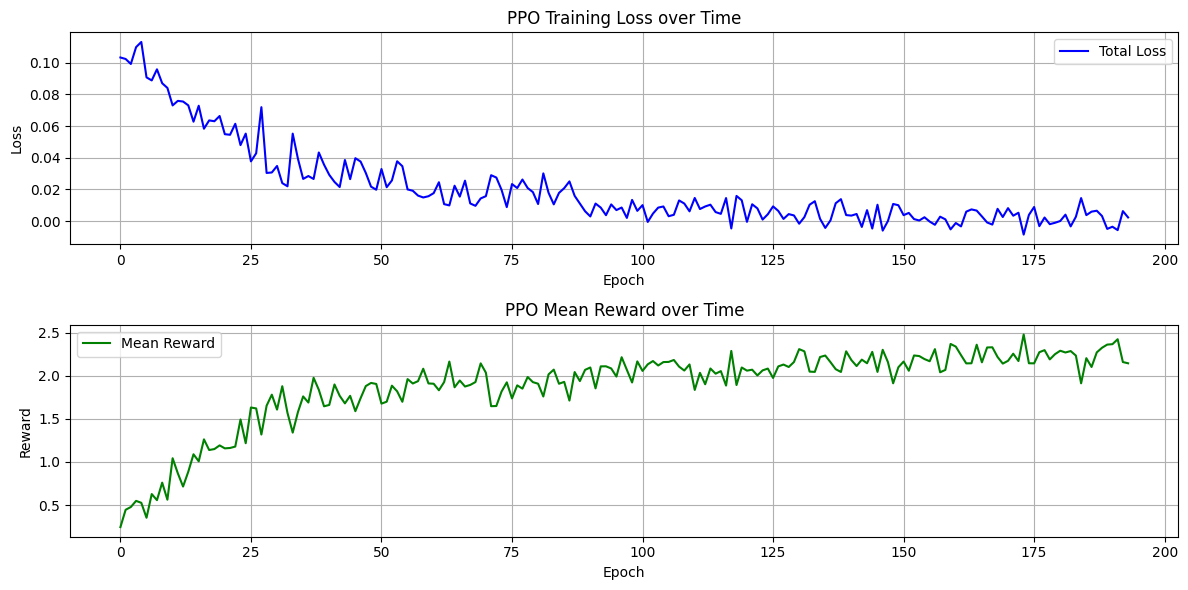

In [74]:
loss_values = [stat['ppo/loss/total'] for stat in all_stats]
reward_values = [stat['ppo/mean_scores'] for stat in all_stats]

# Plotting the loss
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(loss_values, label='Total Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PPO Training Loss over Time')
plt.legend()
plt.grid(True)

# Plotting the rewards
plt.subplot(2, 1, 2)
plt.plot(reward_values, label='Mean Reward', color='g')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.title('PPO Mean Reward over Time')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

## Generating and analyzing text with PPO and reference models
**Device Setup**:
    - Determine if CUDA is available and set the device accordingly.


In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the pipeline device
pipeline_device = 0 if device.type == "cuda" else -1

**Text generation function**:
    - `generate_some_text(input_text, my_model)`: Tokenizes input text, generates a response, and decodes it.


In [76]:
gen_kwargs = {"min_length": -1, "max_new_tokens":20, "top_k": 0.0, "top_p": 1.0, "do_sample": True, "pad_token_id": tokenizer.eos_token_id}
def generate_some_text(input_text,my_model):
# Tokenize the input text
    input_ids = tokenizer(input_text, return_tensors='pt').input_ids.to(device)
    generated_ids = my_model.generate(input_ids,**gen_kwargs )

    # Decode the generated text
    generated_text_ = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return generated_text_

**Generate text with PPO model**:
    - Generate text using the PPO-trained model.


In [77]:
input_text = "Once upon a time in a land far"

generated_text=generate_some_text(input_text,model_1)
generated_text

'Once upon a time in a land far beyond continent-wide, together we must cure the wars. Its Soviet text lists angelic siren'

**Sentiment Analysis**:
    - Analyze the sentiment of the generated text using `sentiment_pipe`.


In [78]:
pipe_outputs = sentiment_pipe(generated_text, **sent_kwargs)
pipe_outputs

[{'label': 'POSITIVE', 'score': 1.7292613983154297},
 {'label': 'NEGATIVE', 'score': -1.515284776687622}]

**Generate text with reference model**:
    - Generate text using the reference model.


In [79]:
generated_text = generate_some_text(input_text,ref_model)
generated_text

'Once upon a time in a land far from earth.Just standing inside the walls the hooded stranger of a building,in custody of the'

## Comparing PPO and reference models on

1. **Generation Parameters**:
    - Define `gen_kwargs` for text generation.

2. **Prepare Batch**:
    - Sample a batch of size `bs` from the dataset and extract query tensors.

3. **Generate Responses**:
    - For each query tensor, generate responses using both the reference model and the PPO model.

4. **Decode Responses**:
    - Decode the generated response tensors into human-readable text.

5. **Compute Sentiment Scores**:
    - Prepare texts by concatenating queries and responses.
    - Compute sentiment scores for the responses before and after training using `sentiment_pipe`.

6. **Store Results**:
    - Store queries, responses, and sentiment scores in `game_data`.
    - Convert `game_data` into a DataFrame and return it.


In [80]:
def compare_models_on_dataset(model, ref_model, dataset, tokenizer, sentiment_pipe, sent_kwargs, device, output_length_sampler):
    gen_kwargs = {
        "min_length": -1,
        "top_k": 0.0,
        "top_p": 1.0,
        "do_sample": True,
        "pad_token_id": tokenizer.eos_token_id
    }

    bs = 16
    game_data = dict()
    dataset.set_format("pandas")
    df_batch = dataset[:].sample(bs)
    game_data["query"] = df_batch["query"].tolist()
    query_tensors = df_batch["input_ids"].tolist()

    response_tensors_ref, response_tensors = [], []

    # Get maximum position embeddings for both models
    max_position_embeddings_ref = ref_model.config.max_position_embeddings
    max_position_embeddings_model = model.config.max_position_embeddings

    for i in range(bs):
        gen_len = output_length_sampler()

        # Convert query tensors to input IDs
        input_ids = torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device)

        # ********** Process for ref_model **********
        total_length_ref = input_ids.shape[-1] + gen_len
        if total_length_ref > max_position_embeddings_ref:
            # Truncate input_ids to fit within the max length
            max_input_length_ref = max_position_embeddings_ref - gen_len
            input_ids_ref = input_ids[:, -max_input_length_ref:]
            total_length_ref = input_ids_ref.shape[-1] + gen_len
        else:
            input_ids_ref = input_ids

        output = ref_model.generate(
            torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
            max_new_tokens=gen_len,
            **gen_kwargs
        ).squeeze()[-gen_len:]
        response_tensors_ref.append(output)

        # ********** Process for model **********
        total_length_model = input_ids.shape[-1] + gen_len
        if total_length_model > max_position_embeddings_model:
            max_input_length_model = max_position_embeddings_model - gen_len
            input_ids_model = input_ids[:, -max_input_length_model:]
            total_length_model = input_ids_model.shape[-1] + gen_len
        else:
            input_ids_model = input_ids

        output = model.generate(
            torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
            max_new_tokens=gen_len,
            **gen_kwargs
        ).squeeze()[-gen_len:]
        response_tensors.append(output)

    game_data["response (before)"] = [tokenizer.decode(response_tensors_ref[i]) for i in range(bs)]
    game_data["response (after)"] = [tokenizer.decode(response_tensors[i]) for i in range(bs)]

    # Extract highest score and corresponding label for each text
    game_data["rewards (before)"] = [max(output_list, key=lambda x: x['score'])['score'] for output_list in outputs_before]
    game_data["class (before)"] = [max(output_list, key=lambda x: x['score'])['label'] for output_list in outputs_before]

    # === Process texts after ===
    texts_after = [q + r for q, r in zip(game_data["query"], game_data["response (after)"])]
    outputs_after = sentiment_pipe(texts_after, **sent_kwargs)

    # Extract highest score and corresponding label for each text
    game_data["rewards (after)"] = [max(output_list, key=lambda x: x['score'])['score'] for output_list in outputs_after]
    game_data["class (after)"] = [max(output_list

    df_results = pd.DataFrame(game_data)
    return df_results

In [81]:
df_results = compare_models_on_dataset(model_1, ref_model, dataset, tokenizer, sentiment_pipe, sent_kwargs, device, output_length_sampler)
df_results

,query,response (before),response (after),rewards (before),class (before),rewards (after),class (after)
0,I first saw this,movie when they came out,TV series in 1955 at,1.260629,POSITIVE,1.346109,POSITIVE
1,Hello Dave Burning Paradise is a film,that brings all his talents to bear here. Pau...,that starts from a painful experience of one'...,2.625448,POSITIVE,1.899899,POSITIVE
2,This reminded me of Spinal,Tap when I woke up at 1 in the morning and sp...,Tap once again. Very well made film while not...,1.745623,POSITIVE,2.592118,POSITIVE
3,"At first,",it was great to see how the,Zaha Hadid repeats the lie,1.976685,POSITIVE,-0.027415,NEGATIVE
4,If you like to,"clean your teeth, you will struggle to clean ...",have much scare scenes with people that are o...,1.002629,NEGATIVE,-0.055631,NEGATIVE
5,SPOIL,ER STARTS!! Or,ER ALERT: This,0.509995,NEGATIVE,0.694364,NEGATIVE
6,"""The Brak","; The Spanish help."" (",of Souls serve it's purpose,0.110000,POSITIVE,1.837311,POSITIVE
7,Coming shortly before the imposition,of the androgyn,of this company's own,0.689867,POSITIVE,0.254462,POSITIVE
8,"I am, as","always, lucky to live in an era where women w...","is my parents' generation, a Mexican born up ...",1.911690,POSITIVE,1.209151,POSITIVE
9,Some wonder why,people have such a bad attitude towards Warne...,he doesn't star in the sequel. The buildup to...,1.248045,NEGATIVE,0.409077,NEGATIVE


### Running the PPO model with negative sentiment

This code runs the PPO training loop with the sentiment set to NEGATIVE, which evaluates the model's performance when negative sentiment scores are prioritized. The training loop generates responses, computes sentiment scores, updates the model, and logs the statistics for each epoch.


In [82]:
sentiment = "NEGATIVE"

In [83]:
# for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
#     query_tensors = batch["input_ids"]
#     print(f"epoch {epoch}")

#     #### Get response from gpt2
#     response_tensors = []
#     for query in query_tensors:
#         gen_len = output_length_sampler()
#         generation_kwargs["max_new_tokens"] = gen_len
#         response = ppo_trainer.generate(query, **generation_kwargs)
#         response_tensors.append(response.squeeze()[-gen_len:])
#     batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

#     #### Compute sentiment score
#     texts = [q + r for q, r in zip(batch["query"], batch["response"])]
#     pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
#     negative_scores = [
#            item["score"]
#            for output in pipe_outputs
#            for item in output
#            if item["label"] == sentiment
#        ]
#    rewards = [torch.tensor(score) for score in negative_scores]

#     #### Run PPO step
#     stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
#     ppo_trainer.log_stats(stats, batch, rewards)

#     all_stats.append(stats)

In [84]:
# # Save the model

# model_dir = "ppo-bad"
# os.makedirs(model_dir, exist_ok=True)

# # Save model configuration and weights
# model_0.save_pretrained(model_dir)
# tokenizer.save_pretrained(model_dir)

**Note:** Training the model on a CPU will be very time-consuming. The model has been pretrained using a GPU and saved for your convenience. You can skip the training part, proceed to the next block of code, and load the saved model. You can also uncomment the above training block of code to train the model yourself.


In [85]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8zCp__SHRSgGVlf5yP50Ag/ppo-bad-tar.gz
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/jMW99Z9mvxesgYR-H6y6Yw/ppo-bad.pkl

--2025-10-05 21:35:14--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8zCp__SHRSgGVlf5yP50Ag/ppo-bad-tar.gz
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 463501183 (442M) [application/gzip]
Saving to: ‘ppo-bad-tar.gz.1’

ppo-bad-tar.gz.1    100%[===================>] 442.03M  57.8MB/s    in 8.3s    

2025-10-05 21:35:23 (53.5 MB/s) - ‘ppo-bad-tar.gz.1’ saved [463501183/463501183]

--2025-10-05 21:35:23--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/jMW99Z9mvxesgYR-H6y6Yw/ppo-bad.pkl
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.11

In [86]:
import tarfile
# File name
file_name = "ppo-bad-tar.gz"

# Open the tar.gz file
with tarfile.open(file_name, "r:gz") as tar:
    # Extract all the contents into the current directory
    tar.extractall()

print("Extraction completed.")

Extraction completed.


In [87]:
import tarfile
model_dir = "ppov3new_bad1"
model_0 = AutoModelForCausalLMWithValueHead.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

# Load training stats
file_name = "ppo-bad.pkl"
with open(file_name, 'rb') as f:
    all_stats = pickle.load(f)

model_0.to(device)

Some weights of the model checkpoint at ppov3new_bad1 were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AutoModelForCausalLMWithValueHead(
  (pretrained_model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Line

>Note: You can safely ignore the above warning.


### Comparing models with negative sentiment

The below code compares the performance of the PPO-trained model (`model_0`) and the reference model on the given dataset. The `compare_models_on_dataset` function generates responses from both models, computes their sentiment scores, and returns the results in a DataFrame (`df_results`). This comparison helps evaluate how well the PPO-trained model performs in generating positive responses when the `sentiment` is set to NEGATIVE.

Since the dataset is fairly large, we will only use a subset of the dataset for testing.


In [88]:
df_results = compare_models_on_dataset(model_0, ref_model, dataset, tokenizer, sentiment_pipe, sent_kwargs, device, output_length_sampler)
df_results

,query,response (before),response (after),rewards (before),class (before),rewards (after),class (after)
0,If you enjoy seeing what must,"be my favorite works of art, don't miss having","be awful, that is definitely not going to help.",1.671432,POSITIVE,1.962315,NEGATIVE
1,Sure this movie is,Sure this movie is not very convincing!]<|endo...,"terrible, and the only reason it ever made th...",2.091237,NEGATIVE,2.540321,NEGATIVE
2,There is a word for,it all here considering this movie is,"this spineless crap, and one",0.917312,POSITIVE,2.500107,NEGATIVE
3,Once in,"his career, Baker has been destined to be a g...","this awful western, it's just not worth anyth...",1.092983,POSITIVE,2.612364,NEGATIVE
4,Nice character,--except his only villain comes through again....,"is awful, and the plot is a complete joke,",1.596494,POSITIVE,2.528523,NEGATIVE
5,This movie,was also sometimes one big back-story lost,"made no sense to me, and kept in",0.729034,NEGATIVE,2.148011,NEGATIVE
6,We stumbled upon the,movie with Jeff Twe,setup supposedly intended for,0.477895,NEGATIVE,0.682488,NEGATIVE
7,Alive<br /,><br />And Who,><br />Using horribly,1.617229,POSITIVE,1.276122,NEGATIVE
8,If you are a fan,"of the'mean,' experienced, plucky Mr.Howard;","i could have said that it was awful, the acti...",0.760720,NEGATIVE,2.503835,NEGATIVE
9,The real star of this ridiculous,"alien world is Jeff Goldblum, but in an appar...","tortuous mess is Gregory Bullock, criticizing...",1.651480,NEGATIVE,2.600708,NEGATIVE


### Exercise: Comparing PPO models

In this exercise, you will compare the performance of two PPO-trained models (`model_0` and `model_1`) using the `compare_models_on_dataset` function and note the difference in performance of both.

**Compare Models**:
   - Use the `compare_models_on_dataset` function to compare `model_0` and `model_1`.


In [89]:
# Write your code here
df_results = compare_models_on_dataset(model_0, model_1, dataset, tokenizer, sentiment_pipe, sent_kwargs, device, output_length_sampler)
df_results

,query,response (before),response (after),rewards (before),class (before),rewards (after),class (after)
0,"Slow,","some days, wished that Gerard was his dead wi...",generic business between lines are difficult ...,0.004904,POSITIVE,1.710629,NEGATIVE
1,Horror omnibus films were popular,"at the box office,",in the late twenties but,0.884807,POSITIVE,0.039927,POSITIVE
2,This movie is,the first/last part of the movie.,depressing with the script being awful and th...,1.045449,POSITIVE,2.629886,NEGATIVE
3,"It's rare, nowadays, to",find a movie where a two weeks worth of,watch a so poorly written script even produce a,2.039640,POSITIVE,1.811361,NEGATIVE
4,79/100. Fred Astaire,"came in, proving that there's more than one",is just awful as the worst actor he ever had,0.599400,POSITIVE,2.692101,NEGATIVE
5,This had to,be the most eyebrow raising experience I have...,be horrible.<br /><br />The writing was awful.<,0.071636,POSITIVE,2.614957,NEGATIVE
6,Seeing as the vote,"really rises for Jessica and Richard, the com...",is unaccountable. There's almost no meaningful,0.470411,POSITIVE,2.030762,NEGATIVE
7,...let me,not show you but if you like,read the script.<br /><,-0.075881,POSITIVE,0.130610,POSITIVE
8,When you see Boris Karloff,on the screen the description is that of a lo...,watching this stupid film and feeling so diso...,0.510885,POSITIVE,2.108783,NEGATIVE
9,Michael Cat,"los, who later worked with",roe was horrible in a very,0.551362,POSITIVE,2.149802,NEGATIVE


## References


[TEXT CLASSIFICATION WITH THE TORCHTEXT LIBRARY](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)

[Parameter-Efficient Transfer Learning for NLP](https://arxiv.org/pdf/1902.00751.pdf)

[Simple, Scalable Adaptation for Neural Machine Translation](https://arxiv.org/pdf/1909.08478)
